In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for the Natural Language Processing
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

# Loading text corpus

In [16]:
# Folder names
PREFIX = "tablesCleaned/"

AMAZON = "amazon_clean_1.csv"
AMAZON_RATINGS = "amazon_comments_clean_0.csv"

In [17]:
dfAmz = pd.read_csv(PREFIX+AMAZON, ";", encoding='latin_1')
dfAmzRat = pd.read_csv(PREFIX+AMAZON_RATINGS, ";", encoding='latin_1')

In [18]:
def dfColumnToList(df, column):
    return df[column].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))

In [19]:
# Prepare data
dfAmz['titleCleared'] = dfColumnToList(dfAmz, 'titleCleared')
dfAmz['attrCleared'] = dfColumnToList(dfAmz, 'attrCleared')
dfAmz['descriptionCleared'] = dfColumnToList(dfAmz, 'descriptionCleared')

dfAmzRat['titleCleared'] = dfColumnToList(dfAmzRat, 'titleCleared')
dfAmzRat['reviewCleared'] = dfColumnToList(dfAmzRat, 'reviewCleared')

In [20]:
# Build text corpus
sentences = []

for _, row in dfAmz.iterrows():
    sentences += [row['titleCleared']]
    sentences += [row['descriptionCleared']]
    sentences += [row['attrCleared']]
    for _, comment in dfAmzRat[dfAmzRat['asin'] == row['asin']].iterrows():
            sentences += [comment['titleCleared'] + comment['reviewCleared']]

# Further preparation of the text corpus

In [21]:
stemmer = Cistem()

In [22]:
# Create list of stopwords and puctuation
stpwrds = stopwords.words('english') + stopwords.words('german') + list(string.punctuation)

**Lower sentences, remove stopwords and interpunctuation and stem words.**

In [23]:
lower_sents = []
for s in sentences:
    lower_sents.append([stemmer.segment(w.lower())[0] for w in s if w.lower() not in stpwrds])

**Processing of n-grams**

In [24]:
lower_bigram = Phraser(Phrases(lower_sents, min_count=32, threshold=64))

In [26]:
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

# Train model

In [27]:
model = Word2Vec(sentences=clean_sents, vector_size=64, sg=1, window=10, min_count=10, workers=4)

In [28]:
# Saving
# model.save('clean_first_model.w2v')

In [29]:
# Loading
# model = gensim.models.Word2Vec.load('clean_first_model.w2v')

# Usability and visualisation 

In [30]:
# Display number of words that occoured at least 10 times
len(model.wv.index_to_key)

18085

In [31]:
# Show one vector
model.wv['kaffee']

array([ 0.33055088,  0.47860166,  0.07413681,  0.20224579,  0.09495919,
       -0.4372453 ,  0.11807624,  0.06426198,  0.09242462, -0.12139492,
       -0.06279558, -0.36144742, -0.21598242, -0.08695944,  0.96469015,
        0.48213634, -0.00421778,  0.28689054,  0.19263005,  0.0810423 ,
       -0.1979155 ,  0.36045   , -0.09559229, -0.60170555,  0.43733937,
       -0.20159332, -0.233952  , -0.47065693,  0.5946524 ,  0.61036587,
       -0.4188877 ,  0.03758259, -0.12802072, -0.25337204,  0.4214329 ,
        0.6773183 , -0.7244187 ,  0.28174177, -0.1503661 , -0.29976213,
       -0.36061454,  0.57316256, -0.05764528,  0.17252356,  0.6051175 ,
        0.890471  ,  0.05786922, -0.51045686,  0.68727183,  0.5976498 ,
        0.26167786,  0.198308  ,  0.9654701 ,  0.4178601 , -0.11421202,
       -0.18179592,  0.0603266 , -0.21688102, -0.35946497,  0.25799257,
       -0.40933713, -0.24087125, -0.21215947,  0.4073721 ], dtype=float32)

**Show most simlar words**

In [39]:
# e.g. Top 10 for fussball
model.wv.most_similar('fussball', topn=10)

[('fußball', 0.8453207612037659),
 ('bundesliga', 0.7141079306602478),
 ('football', 0.7089871764183044),
 ('em', 0.7088258862495422),
 ('stadio', 0.7069311141967773),
 ('schiedsrich', 0.7033929228782654),
 ('hüpfball', 0.7016676664352417),
 ('fußballfeld', 0.6975122690200806),
 ('fußballeri', 0.6973695755004883),
 ('spiellei', 0.6964539289474487)]

**Show word that doesnt fit in**

In [40]:
model.wv.doesnt_match("auto fahr fussball kasette suv".split())

'fussball'

**Show how similar two words are**

In [41]:
model.wv.similarity('auto', 'fussball')

0.32499003

In [42]:
model.wv.similarity('kind', 'spielzeug')

0.6230322

**Show similar words for vector operation**

In [44]:
model.wv.most_similar(positive=['fussball','geschenk'])

[('taschenfüll', 0.7923922538757324),
 ('geschenkidee', 0.7900161147117615),
 ('konfirmatio', 0.7874178886413574),
 ('geburtstag', 0.784417450428009),
 ('fußballmama', 0.7777538299560547),
 ('kommunio', 0.774941086769104),
 ('einschulung', 0.7677206993103027),
 ('fussballfa', 0.7581696510314941),
 ('taufgeschenk', 0.756084144115448),
 ('geburtstagsgeschenk', 0.7522637248039246)]

**Visualisation of the model in two dimensions**

In [36]:
tsne = TSNE(n_components=2, n_iter=1000)
X_2d = tsne.fit_transform(model.wv[model.wv.key_to_index])
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = model.wv.key_to_index.keys()

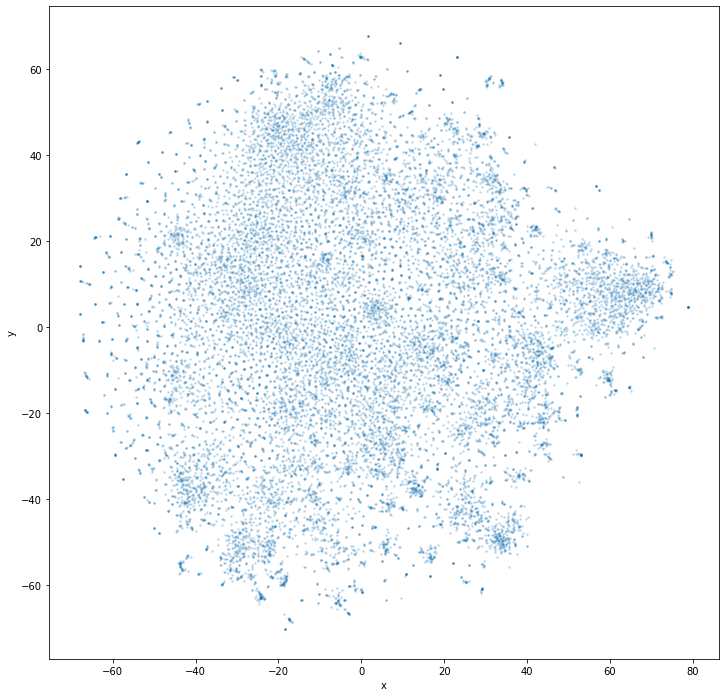

In [37]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), marker='.', s=10, alpha=0.2)

**Create interactive two dimension visualisation**

In [38]:
output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

Loading BokehJS ...